## Transferência de Estilo neural artístico usando PyTorch

##### Separando Estilo e Conteúdo

A transferência de estilo depende da separação do conteúdo e do estilo de uma imagem. Dada uma imagem de conteúdo e uma imagem de estilo, pretendemos criar uma nova imagem de destino que deve conter nosso conteúdo desejado e componentes de estilo:

##### objetos e sua disposição são semelhantes à da imagem do conteúdo

Estilo, cores e texturas são semelhantes aos da imagem de estilo. Um exemplo é mostrado abaixo, onde a imagem do conteúdo é de um cidade com uma igreja na parte centra e a imagem do estilo é um Quadro de Van Godgh, Sterrennacht de 1889. A imagem alvo gerada ainda contém a igreja, mas é estilizada com as caractetísticas de Van Gogh em bloco da imagem de estilo!

![titlew](img/vgg19.png)

### Separando Estilo e Conteúdo

A transferência de estilo depende da separação do conteúdo e do estilo de uma imagem. Dada uma imagem de conteúdo e uma imagem de estilo, pretendemos criar uma nova imagem de destino que deve conter nosso conteúdo desejado e componentes de estilo:

* objetos e sua disposição são semelhantes à da **imagem do conteúdo**;

* estilo, cores e texturas são semelhantes aos da **imagem de estilo**;

Um exemplo é mostrado abaixo, onde a imagem do conteúdo é de um igreja e a imagem do estilo é o Quadro Noite Estrelada de Van Gogh. A imagem alvo gerada ainda contém a igreja, mas é estilizada como o quadro!

In [1]:
# Importar Recursos
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

## Carregando o VV19 (recursos)

VGG19 é dividido em duas partes:

vgg19.features, que são todas as camadas convolucionais e de pooling
vgg19.classifier, que são as três camadas lineares do classificador no final. Precisamos apenas da parte dos recursos, que vamos carregar e "congelar" os pesos abaixo.

In [3]:
# Obter a parte "recursos" do VGG19 (não precisamos da parte "Classificador")
vgg = models.vgg19(pretrained=True).features

# Congela todos os parâmetros VGG, pois estamos apenas otimizando a imagem do destino
for param in vgg.parameters():
    param.requires_grad_(False)

In [4]:
# Mover o modelo para GPU, se disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### Carregar conteúdo e imagens de estilo

Você pode carregar as imagens que quiser! Abaixo, fornecemos uma função auxiliar para carregar em qualquer tipo e tamanho de imagem. A função load_image também converte imagens em tensores normalizados.

Além disso, será mais fácil ter imagens menores e comprimir o conteúdo e estilizar as imagens para que tenham o mesmo tamanho.

In [5]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    
    image = Image.open(img_path).convert('RGB')
    
    # Imagens grandes retardarão o processamento
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # Descartar o canal alfa transparanete (que é :3) e adicionar a dimensão do lote
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

Em seguida, estou carregando imagens por nome de arquivo e forçando a imagem de estilo a ter o mesmo tamanho da imagem de conteúdo.

Baixe o conteúdo necessário e as imagens de estilo ...

In [6]:
# Carregar no conteúdo e no estilo da imagem 
content = load_image('img/matriz_SBC.jpg').to(device)

# Redimensionar estilo para combinar com o conteúdo, torna o código mais fácil
style = load_image('img/quadro.png', shape=content.shape[-2:]).to(device)

In [7]:
# Função auxiliar para anular a normalização de uma imagem e 
#convertê_lo de uma imagem do Tensor em uma imagem Numpy para exibição
def im_convert(tensor):
    """ Exibe um tensor como uma imagem. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

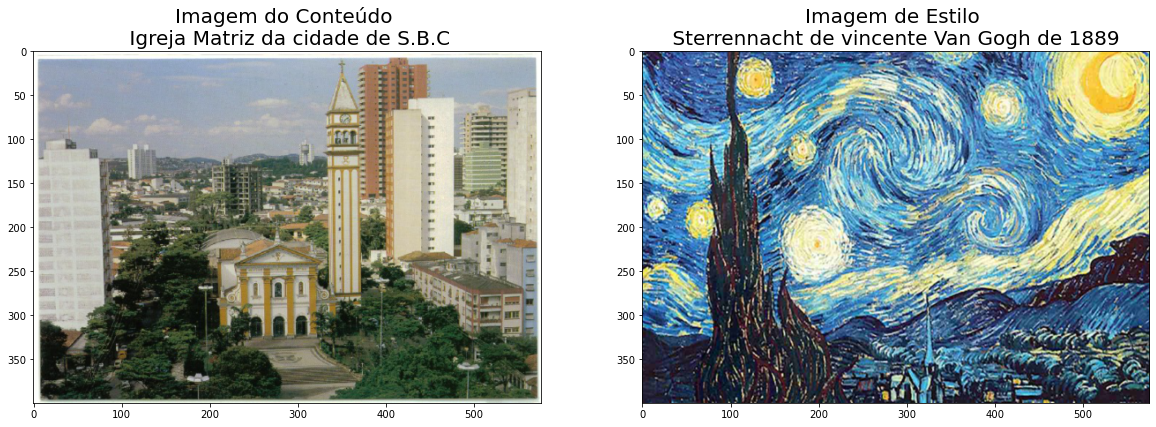

In [17]:
# Exibir as imagens 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Conteúdo e estilo estão lado a lado
# Imagem a esquerda
ax1.imshow(im_convert(content))
ax1.set_title("Imagem do Conteúdo \n Igreja Matriz da cidade de S.B.C",fontsize = 20)

# Imagem a direita
ax2.imshow(im_convert(style))
ax2.set_title("Imagem de Estilo \n Sterrennacht de vincente Van Gogh de 1889 ", fontsize = 20)

# Carregando as imagens
plt.show()

## Camadas VGG19

Para obter as representações de conteúdo e estilo de uma imagem, temos que passar uma imagem adiante através da rede VGG19 até chegarmos à (s) camada (s) desejada (s) e então obter a saída dessa camada.

In [9]:
# Mostrar a estrutura VGG19 para que você possa ver os nomes das várias camadas
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Recursos de conteúdo e estilo

Abaixo, complete o mapeamento dos nomes das camadas para os nomes encontrados no papel para a representação do conteúdo e a representação do estilo.

In [10]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    ## Complete mapeamento de nomes de camada de VGGNet de PyTorch para nomes do papel
    # Necessita das camadas para as representações de conteúdo e estilo de uma imagem
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## Representação de conteúdo
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules é um dicionário contendo cada módulo do modelo
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

## Gram Matrix

A saída de cada camada convolucional é um Tensor com dimensões associadas a batch_size, a depth, d e alguma altura e largura (h, w). A matriz de Gram de uma camada convolucional pode ser calculada da seguinte forma:

* Obtenha a profundidade, altura e largura de um tensor usando <code>**batch_size, d, h, w = tensor.size**</code>;
* Remodele esse tensor para que as dimensões espaciais sejam achatadas;
* Calcule a matriz de grama multiplicando o tensor remodelado por sua transposta;

Observação: você pode multiplicar duas matrizes usando <code>**torch.mm (matriz1, matriz2)**</code>.

In [11]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

## Juntando tudo

Agora que escrevemos funções para extrair recursos e calcular a matriz grama de uma determinada camada convolucional; vamos juntar todas essas peças! Extrairemos nossos recursos de nossas imagens e calcularemos as matrizes de grama para cada camada em nossa representação de estilo.

In [12]:
# Obter recursos de conteúdo e estilo apenas uma vez antes do treinamento
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# Calcule as matrizes de grama para cada camada de nossa representação de estilo
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Criar uma terceira imagem "alvo" e prepará-la para a mudança
# É uma boa ideia começar com o alvo como uma cópia de nossa imagem *conteúdo*
# Então altere iterativamente seu estilo
target = content.clone().requires_grad_(True).to(device)

## Perda e Pesos

#### Pesos de estilo de camada individual

Abaixo, você tem a opção de ponderar a representação do estilo em cada camada relevante. É sugerido que você use um intervalo entre 0-1 para ponderar essas camadas. Ao ponderar mais as camadas anteriores (conv1_1 e conv2_1), você pode esperar obter artefatos de estilo maiores em sua imagem de destino resultante. Se você decidir ponderar as camadas posteriores, terá mais ênfase em recursos menores. Isso ocorre porque cada camada tem um tamanho diferente e, juntas, elas criam uma representação de estilo em várias escalas!

#### Peso de conteúdo e estilo

Assim como no artigo, definimos um alpha (content_weight) e um beta (style_weight). Esta proporção afetará o quão estilizada é a sua imagem final. É recomendado que você deixe o content_weight = 1 e defina o style_weight para atingir a proporção desejada.

In [13]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e9  # beta

## Atualizando a meta e calculando as perdas

Você decidirá por uma série de etapas para atualizar sua imagem, isso é semelhante ao loop de treinamento que você viu antes, só que estamos mudando nossa imagem de destino e nada mais sobre VGG19 ou qualquer outra imagem. Portanto, o número de etapas realmente depende de você definir! **Eu recomendo usar pelo menos 2.000 passos para bons resultados.** Porém, você pode querer começar com menos etapas se estiver apenas testando diferentes valores de peso ou experimentando imagens diferentes.

Dentro do loop de iteração, você calculará as perdas de conteúdo e estilo e atualizará sua imagem de destino de acordo.

#### Perda de Conteúdo

A perda de conteúdo será a diferença quadrática média entre os recursos de destino e de conteúdo na camada conv4_2. Isso pode ser calculado da seguinte forma:

<code>content_loss = torch.mean ((target_features ['conv4_2'] - content_features ['conv4_2']) ** 2)</code>

#### Perda de Estilo
A perda de estilo é calculada de maneira semelhante, apenas você tem que iterar através de uma série de camadas, especificadas pelo nome em nosso dicionário <code>style_weights</code>.

<em>Você calculará a matriz de grama para a imagem de destino, <code>target_gram</code> e <code>style_gram</code> de imagem de estilo em cada uma dessas camadas e comparará essas matrizes de grama, calculando o <code>layer_style_loss</code>. Posteriormente, você verá que esse valor é normalizado pelo tamanho da camada.</em>

#### Perda total
Finalmente, você criará a perda total somando as perdas de estilo e conteúdo e ponderando-as com seu alfa e beta especificados!

Intermitentemente, imprimiremos essa perda; não se assuste se a perda for muito grande. Leva algum tempo para que o estilo de uma imagem mude e você deve se concentrar na aparência da imagem de destino, em vez de em qualquer valor de perda. Ainda assim, você deve ver que essa perda diminui ao longo de algumas iterações.

Total loss:  42704207872.0


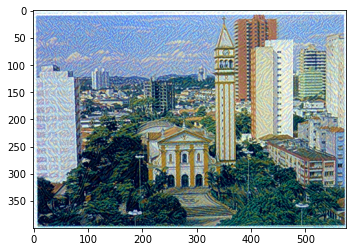

Total loss:  7899498496.0


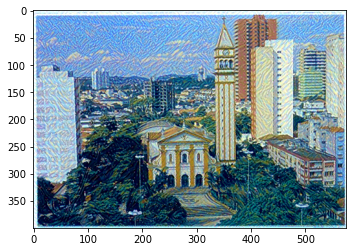

Total loss:  4868208640.0


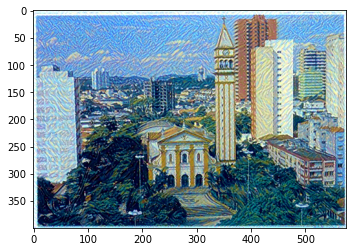

Total loss:  3383648512.0


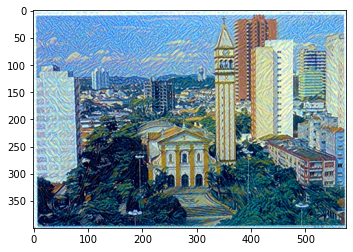

Total loss:  2434329856.0


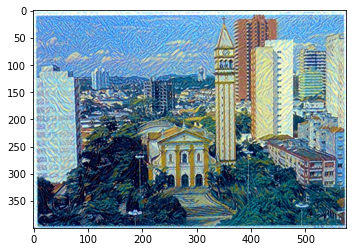

In [15]:
# for displaying the target image, intermittently
show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, vgg)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

## Exibir a imagem de destino

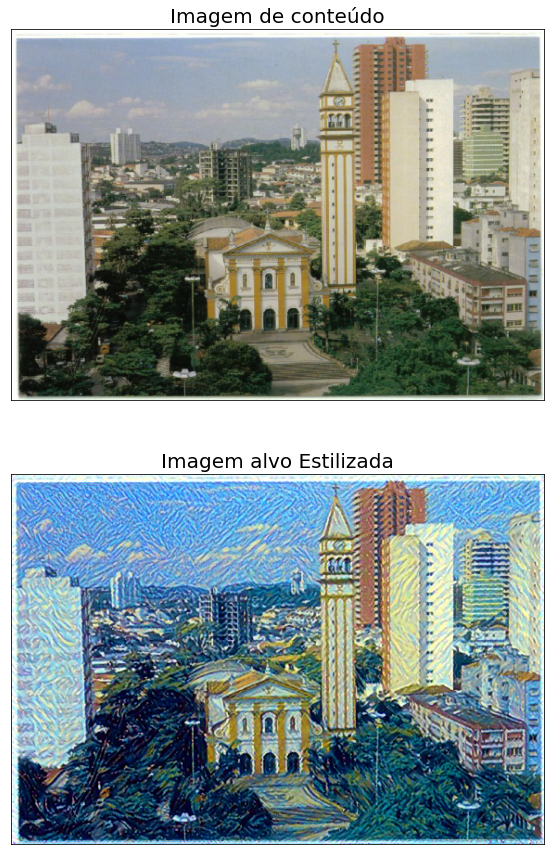

In [21]:
# Exibir conteúdo e imagem final, alvo
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (15,15))
ax1.imshow(im_convert(content))
ax1.set_title("Imagem de conteúdo", fontsize = 20)

ax2.imshow(im_convert(target))
ax2.set_title("Imagem alvo Estilizada", fontsize = 20)
ax1.grid(False)
ax2.grid(False)

#Esconder os eixos da Imagem
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])

plt.show()

## Crédito de Imagem

Igraja Matriz da Cidade de São Bernardo do Campo (https://www.diocesesa.org.br/wp-content/uploads/2016/04/SBC.jpg)

A noite estrelada de Vincent Van Gogh (https://oceanmhs.org/wp-content/uploads/2018/01/starrynight.jpg)


## Fonte de Conteúdo:

<p style="text-align: left;">Site: <a href="http://www.rodolfoterra.com">Rodolfo Terra | Ciência de dados</a></p>

<p style="text-align: left;">Blog: <a href="https://rodolffoterra.github.io/">Aprenda Gratuitamente Linguagem R & Python</a></p>


<p style="text-align: left;">Github: <a href="https://github.com/rodolffoterra">rodolffoterra</a></p>

<p><img style="float: right;" src="img/logo.png" alt="RNA" /></p><br><br><br><br><br>





